In [1]:
from math import log10
from collections import Counter, defaultdict

# 中文 Language Model

In [2]:
filename = "corpus.txt"
V1 = 10000
V2 = 10000**2
k = 10

def to_ngrams(unigrams, length):
    return zip(*[unigrams[i:] for i in range(length)])

unigram_counts, bigram_counts = Counter(), Counter()
with open(filename, 'r') as text_file:
    for line in text_file:
        unigram_counts.update(line)
        bigram_counts.update(to_ngrams(line, 2))

In [3]:
# your code here (probability of word sequences)
# (you can use log to speed up the calculation)

### 階段測試

In [45]:
print(prob_1word(u'清'))
print(prob_1word(u'華'))
print(prob_2words(u'清', u'華'))
print(prob_word_by_word(u'清',u'華'))

-3.25200050182
-3.24249914975
-4.36636366172
-1.1143631599


In [6]:
import pandas
%matplotlib inline
s = pandas.Series(prob_1word(unigram) for unigram in unigram_counts)

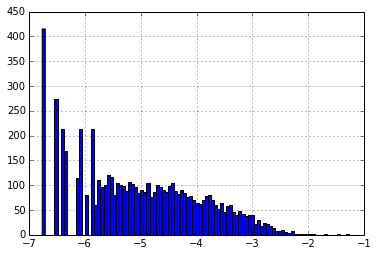

In [7]:
s.hist(bins=100)

# 注音對應表

In [ ]:
with codecs.open("bpmf.txt", 'r', 'utf-8') as bpmf_file:
    # your code here

### 階段測試

In [46]:
bpmf1_to_chars['ㄨ'][:10]

[u'溫',
 u'無',
 u'衛',
 u'罔',
 u'晚',
 u'頑',
 u'挖',
 u'蔚',
 u'烷',
 u'王']


# viterbi

In [ ]:
# your viterbi function here

### 最終測試

(-3.1548887442172044,
 [u'不', u'是'],
 <matplotlib.axes.AxesSubplot object at 0x113c11a10>)


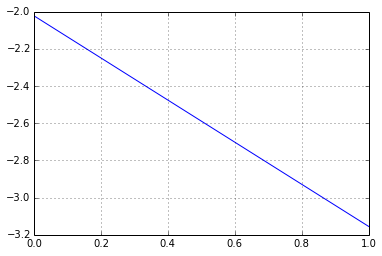

In [26]:
bpmf1s_to_chars('ㄅㄕ')

(-8.53669708842652,
 [u'中', u'華', u'民', u'國', u'政', u'府'],
 <matplotlib.axes.AxesSubplot object at 0x113a22d90>)


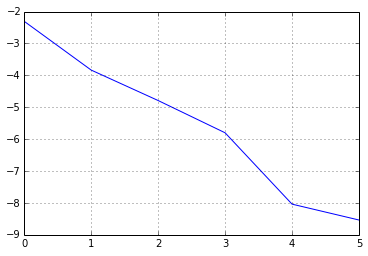

In [27]:
bpmf1s_to_chars(u'ㄓㄏㄇㄍㄓㄈ')

(-10.605441609165581,
 [u'自', u'然', u'語', u'言', u'處', u'理'],
 <matplotlib.axes.AxesSubplot object at 0x113aca210>)


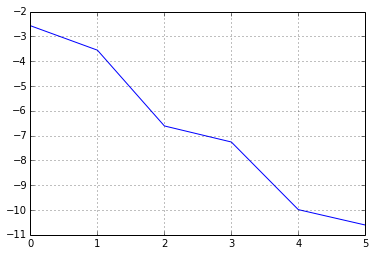

In [28]:
bpmf1s_to_chars(u'ㄗㄖㄩㄧㄔㄌ')

(-6.914017328369664,
 [u'清', u'華', u'大', u'學'],
 <matplotlib.axes.AxesSubplot object at 0x113b1d9d0>)


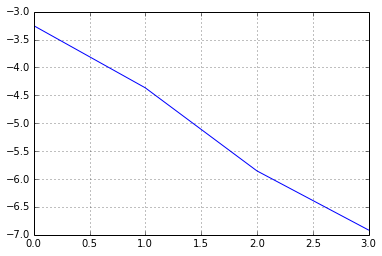

In [29]:
bpmf1s_to_chars(u'ㄑㄏㄉㄒ')

(-6.523886591924057,
 [u'資', u'訊', u'工', u'程'],
 <matplotlib.axes.AxesSubplot object at 0x113cbfd90>)


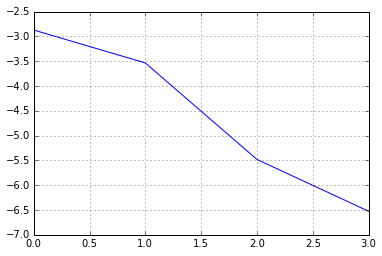

In [30]:
bpmf1s_to_chars(u'ㄗㄒㄍㄔ')

(-8.975520402582456,
 [u'這', u'是', u'一', u'本', u'書'],
 <matplotlib.axes.AxesSubplot object at 0x113cf6090>)


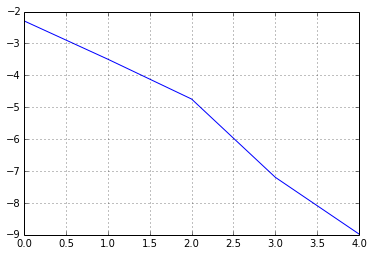

In [31]:
bpmf1s_to_chars(u'ㄓㄕㄧㄅ書')

(-14.798908068226588,
 [u'立',
  u'法',
  u'委',
  u'員',
  u'都',
  u'在',
  u'吵',
  u'架'],
 <matplotlib.axes.AxesSubplot object at 0x113cddbd0>)


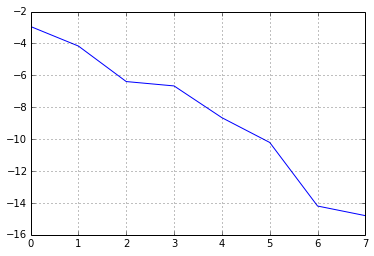

In [32]:
bpmf1s_to_chars(u'ㄌㄈㄨㄩㄉㄗㄔ架')

(-7.211231492855711,
 [u'我', u'想', u'睡', u'覺'],
 <matplotlib.axes.AxesSubplot object at 0x113a9b650>)


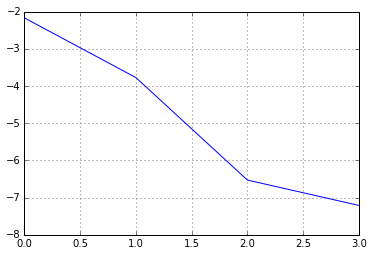

In [33]:
bpmf1s_to_chars(u'ㄨㄒ睡ㄐ')

(-22.126938628228288,
 [u'肚',
  u'子',
  u'很',
  u'餓',
  u'，',
  u'快',
  u'點',
  u'下',
  u'課'],
 <matplotlib.axes.AxesSubplot object at 0x113a7ffd0>)


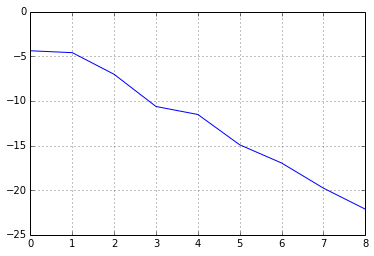

In [34]:
bpmf1s_to_chars(u'肚ㄗㄏㄜ，ㄎ點下ㄎ')